# LFS Survey Data Exploration

The following notebook is my working exploration of the Canadian Labour Force Survey data.

## How to read the notebook

I find it easiest personally when I'm working to do most of my newest work right below the initial blocks of code that load the data. Eventually I want to deploy a database that loads LFS data monthly again and has the ability to attach meaning and transform the data into a semantic layer, but for now I'm doing it all with my python code. With that in mind I use the "Current" section to create my newest work and let it 'fall' down the document as I work. 

Over time I'll take some of my best work

## TO DO

- Need to refactor my code, it seems to have a lot of assumptions build in, and some code I made to calculate the unemployment ra
- Look into why my unemployment rate doesn't seem to align with the StatsCan unemployment rate.
- Deploy this code as an azure function transforming most recently added lfs raw dataset

## Updates

March 28? - wrote a function that, for any subset of the LFS data, replaces columns that require replacement with text, and replaces them. option `replace_variable=False` prevents LFS variable from being replaced by the variable name.

Apr 2 - Realized my solution only replaced qualitative variables column names, but numerical columns remained named as the lfs variable. Need to fix this - potentially start by looking at the statement using `replace_variable`. Maybe write a separate function that replaces these

May 14 - Did a lot of refactoring - finaly put all the variables and the english variable names into a dict, also took the function that replaces the raw LFS data with their categorical labels and the variable names into  `lfshelpers.py` file. This improves code readability. This was driven by the need to get a table to use with PowerBI. Had trouble getting this working

May 14 (Second time) - Had some trouble with the type of the variables being floats because of the null values not being allowed as `int64` in python - it wasn't joining to the corresponding variable in the LFS dataset. Finally managed, with some minor tweaks to the CSV files indices (`1` -> `01`), to get the `join_lfs_var_labels` function working, and I'm using `df.to_csv()` to save a csv file to use in PowerBI. I now have the data in the right format to use PowerBI!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import datetime

#lfshelpers is a file with some helpful structures and functions to assist with reading in the LFS file and converting to a readable format
#lfs_var_labels is a dict that has the lfs variables as keys and the variable names/labels as the values
#join_lfs_var_labels replaces all categorical variables with labels stored externally to their proper labels and has an argument to retain the original variable as the column labels or replace with the variable name
from lfshelpers import lfs_var_labels
from lfshelpers import join_lfs_var_labels

# use glob to get all the csv files 
# in the folder
path = os.getcwd() + '/LFS_Jan2021-Present'
csv_files = glob.glob(os.path.join(path, "*.csv"))
  
print(path)
print(type(csv_files))
print(len(csv_files))
print(csv_files)
print(lfs_var_labels)
# loop over the list of csv files


c:\Users\psych\Repos\stats-can/LFS_Jan2021-Present
<class 'list'>
4
['c:\\Users\\psych\\Repos\\stats-can/LFS_Jan2021-Present\\pub0122.csv', 'c:\\Users\\psych\\Repos\\stats-can/LFS_Jan2021-Present\\pub0222.csv', 'c:\\Users\\psych\\Repos\\stats-can/LFS_Jan2021-Present\\pub0322.csv', 'c:\\Users\\psych\\Repos\\stats-can/LFS_Jan2021-Present\\pub0422.csv']
{'rec_num': 'Order of record in file', 'survyear': 'Survey year', 'survmnth': 'Survey month', 'lfsstat': 'Labour force status', 'prov': 'Province', 'cma': 'Nine largest CMAs', 'age_12': 'Five-year age group of respondent', 'age_6': 'Age in 2 and 3 year groups, 15 to 29', 'sex': 'Sex of respondent', 'marstat': 'Marital status of respondent', 'educ': 'Highest educational attainment', 'mjh': 'Single or multiple jobholder', 'everwork': 'Not currently employed, worked in the past', 'ftptlast': 'Full- or part-time status of last job', 'cowmain': 'Class of worker, main job', 'immig': 'Immigrant status', 'naics_21': 'Industry of main job', 'noc_10

The following code concatenates all the monthly LFS files onto one another back until January 2021 (soon to be March 2020)

In [2]:


lfs = pd.DataFrame([])
#temp is initiatlized to allow the following concatenation to work properly on the first iteration of the loop
temp = pd.DataFrame([])
for f in csv_files:
    
    
    # read the csv file
    lfs = pd.read_csv(f, dtype = np.object)
    
    
    # print the location and filename
    print('Location:', f)
    print('File Name:', f.split("\\")[-1])
      
    # print the content
    print('Content:')
    lfs = pd.concat([temp, lfs])
    print(lfs.head())
    print(lfs.shape)

    temp = lfs
    #this break is just a lazy way to not have this loop capture all data every time I run this notebook. Remove when need full range of data
    

print('final shape:', lfs.shape)


Location: c:\Users\psych\Repos\stats-can/LFS_Jan2021-Present\pub0122.csv
File Name: pub0122.csv
Content:
  REC_NUM SURVYEAR SURVMNTH LFSSTAT PROV CMA AGE_12 AGE_6 SEX MARSTAT  ...  \
0       1     2022       01       1   59   0     08   NaN   1       1  ...   
1       2     2022       01       1   12   0     06   NaN   2       6  ...   
2       3     2022       01       4   46   6     11   NaN   1       1  ...   
3       4     2022       01       2   35   4     05   NaN   2       6  ...   
4       5     2022       01       1   24   0     07   NaN   2       1  ...   

  LKATADS LKANSADS LKOTHERN PRIORACT YNOLOOK TLOLOOK SCHOOLN EFAMTYPE AGYOWNK  \
0     NaN      NaN      NaN      NaN     NaN     NaN       1       06       3   
1     NaN      NaN      NaN      NaN     NaN     NaN       1       18     NaN   
2     NaN      NaN      NaN      NaN     NaN     NaN     NaN       11     NaN   
3     NaN      NaN      NaN      NaN     NaN     NaN       1       01     NaN   
4     NaN      NaN   

In [3]:
refined_lfs = join_lfs_var_labels(lfs, path)
print(refined_lfs.head())

['REC_NUM', 'SURVYEAR', 'SURVMNTH', 'LFSSTAT', 'PROV', 'CMA', 'AGE_12', 'AGE_6', 'SEX', 'MARSTAT', 'EDUC', 'MJH', 'EVERWORK', 'FTPTLAST', 'COWMAIN', 'IMMIG', 'NAICS_21', 'NOC_10', 'NOC_40', 'YABSENT', 'WKSAWAY', 'PAYAWAY', 'UHRSMAIN', 'AHRSMAIN', 'FTPTMAIN', 'UTOTHRS', 'ATOTHRS', 'HRSAWAY', 'YAWAY', 'PAIDOT', 'UNPAIDOT', 'XTRAHRS', 'WHYPT', 'TENURE', 'PREVTEN', 'HRLYEARN', 'UNION', 'PERMTEMP', 'ESTSIZE', 'FIRMSIZE', 'DURUNEMP', 'FLOWUNEM', 'UNEMFTPT', 'WHYLEFTO', 'WHYLEFTN', 'DURJLESS', 'AVAILABL', 'LKPUBAG', 'LKEMPLOY', 'LKRELS', 'LKATADS', 'LKANSADS', 'LKOTHERN', 'PRIORACT', 'YNOLOOK', 'TLOLOOK', 'SCHOOLN', 'EFAMTYPE', 'AGYOWNK', 'FINALWT']
rec_num
<class 'str'>
c:\Users\psych\Repos\stats-can/LFS_Jan2021-Present
c:\Users\psych\Repos\stats-can/LFS_Jan2021-Present/Metadata/rec_num.csv
variable: rec_num
c:\Users\psych\Repos\stats-can/LFS_Jan2021-Present/Metadata/survyear.csv
variable: survyear
c:\Users\psych\Repos\stats-can/LFS_Jan2021-Present/Metadata/survmnth.csv
variable: survmnth
In



#combine month and year into one column
lfs['MNTHYEAR'] = pd.to_datetime(lfs['SURVYEAR'].map(str) + '-'+ lfs['SURVMNTH'].map(str)).dt.strftime('%Y-%m')

#drop month and year as well as record number (REC_NUM) and set the index to the new column
lfs = lfs.drop(['SURVYEAR', 'SURVMNTH'], axis = 1)
lfs = lfs.set_index(['MNTHYEAR', 'REC_NUM'])
print(lfs.info())

In [4]:
#print(refined_lfs.info())
#print(refined_lfs.shape)
#refined_lfs.head()
refined_lfs.to_csv('lfs-jan21-present.csv')

# Current

Below is the "current" cell, as I produce stuff I send it down.

['AHRSMAIN', 'HRLYEARN', 'NOC_10']
ahrsmain
<class 'str'>
c:\Users\psych\Repos\stats-can/LFS_Jan2021-Feb2022
c:\Users\psych\Repos\stats-can/LFS_Jan2021-Feb2022/Metadata/ahrsmain.csv
variable: ahrsmain
c:\Users\psych\Repos\stats-can/LFS_Jan2021-Feb2022/Metadata/hrlyearn.csv
variable: hrlyearn
c:\Users\psych\Repos\stats-can/LFS_Jan2021-Feb2022/Metadata/noc_10.csv
variable: noc_10
Index(['Occupation at main job'], dtype='object')
                  AHRSMAIN  HRLYEARN                         NOC_10
MNTHYEAR REC_NUM                                                   
2021-01  1           400.0    1600.0  Sales and service occupations
         2           225.0    4078.0             Health occupations
         3             NaN       NaN                            NaN
         4             NaN       NaN                            NaN
         5             NaN       NaN                            NaN
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 83787 entries, ('2021-01', 1) to ('2021-01'

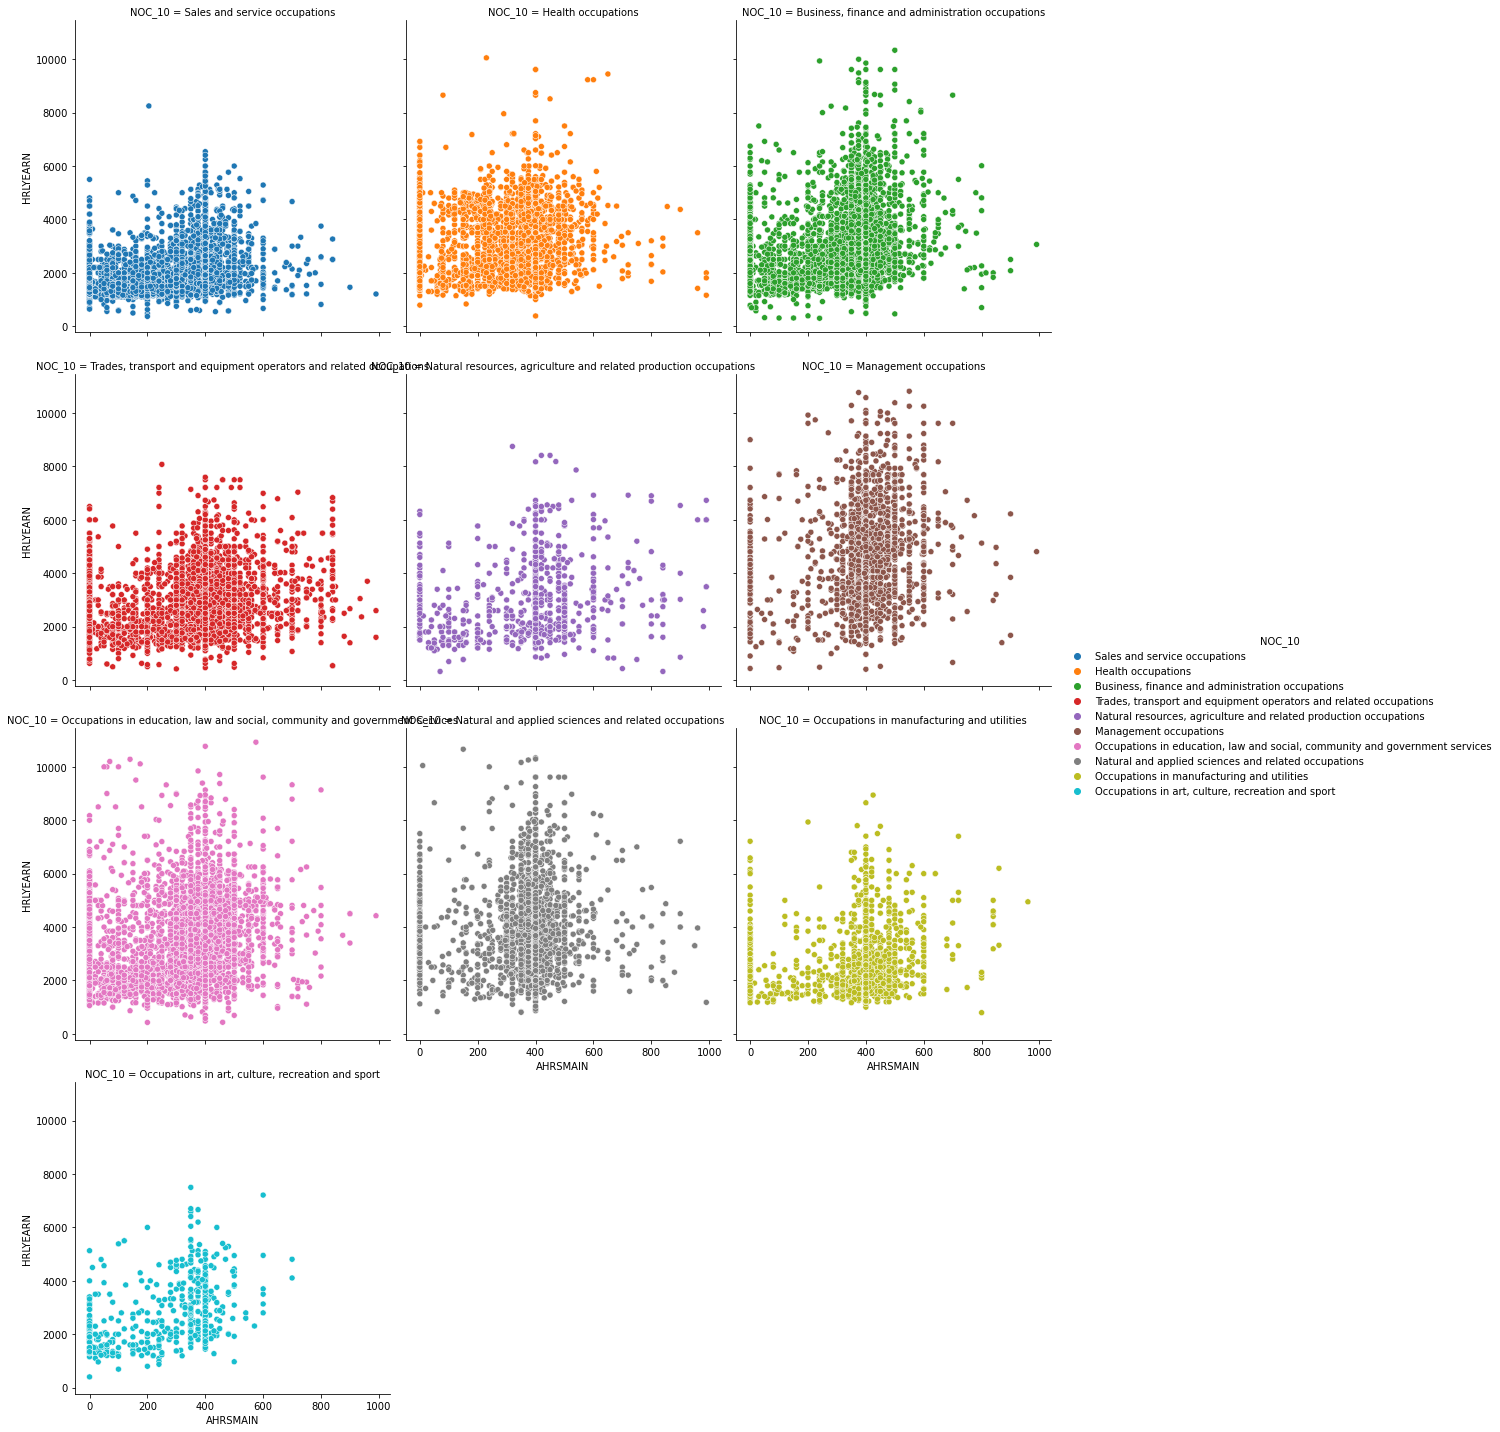

In [7]:
wages = join_lfs_var_labels(lfs[['AHRSMAIN', 'HRLYEARN', 'NOC_10']], path, replace_variables=False)
wages.info()
sns.relplot(x=wages['AHRSMAIN'], y = wages['HRLYEARN'], hue = wages['NOC_10'], kind = 'scatter', col = wages['NOC_10'], col_wrap = 3)
plt.show()

### Questions on above
- I notice that there are a number of cases where people have hourly wages but no regular hours worked - why is this?
    - 
- Looks like with managers they all tend to work lots of hours but their hourly wages really vary 
- Comment: honestly how

<AxesSubplot:xlabel='AHRSMAIN', ylabel='Count'>

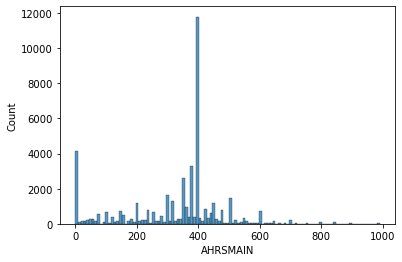

In [5]:
sns.histplot(wages['AHRSMAIN'])

<AxesSubplot:xlabel='HRLYEARN', ylabel='Count'>

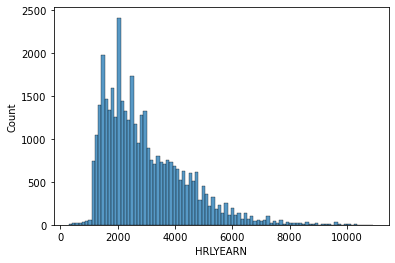

In [6]:
sns.histplot(wages['HRLYEARN'])

<ipython-input-9-91fd9cee349d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wages['YRLYEARN'] = wages['AHRSMAIN']*wages['HRLYEARN']*52/1000


<AxesSubplot:xlabel='YRLYEARN', ylabel='Count'>

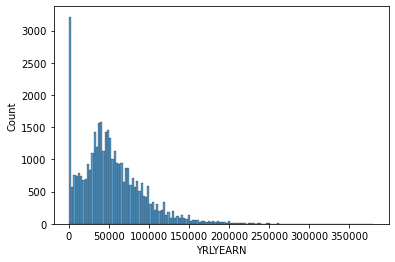

In [9]:
wages['YRLYEARN'] = wages['AHRSMAIN']*wages['HRLYEARN']*52/1000
sns.histplot(wages['YRLYEARN'])

# Questions and comments
- From the work I did above, the large number of people with 0 `YRLYEARN` makes more sense since there appears to be many people with 0  hours worked despite a non-zero hourly earnings - I would suspect their hours worked is captured elsewhere?

# Unemployement and labor force by month

Some initial questions to get started
- What is the unemployment rate per month? (*DONE*)
- What is the labor force participation rate by month?(*DONE*)

- Is there any kind of seasonality to these metrics? (need data outside my initial range of 'Jan 21 - Feb 22')

In [10]:
unemployment = join_lfs_var_labels(lfs[['LFSSTAT', 'PROV']], path, replace_variables=False)
unemployment.info()

['LFSSTAT', 'PROV']
lfsstat
<class 'str'>
c:\Users\psych\Repos\stats-can/LFS_Jan2021-Feb2022
c:\Users\psych\Repos\stats-can/LFS_Jan2021-Feb2022/Metadata/lfsstat.csv
variable: lfsstat
Index(['Labour foce status'], dtype='object')
                  PROV              LFSSTAT
MNTHYEAR REC_NUM                           
2021-01  1          48    Employed, at work
         2          13    Employed, at work
         3          11  Not in labour force
         4          12  Not in labour force
         5          35  Not in labour force
c:\Users\psych\Repos\stats-can/LFS_Jan2021-Feb2022/Metadata/prov.csv
variable: prov
Index(['Province'], dtype='object')
                              LFSSTAT                  PROV
MNTHYEAR REC_NUM                                           
2021-01  1          Employed, at work               Alberta
         2          Employed, at work         New Brunswick
         3        Not in labour force  Prince Edward Island
         4        Not in labour force      

<AxesSubplot:xlabel='count', ylabel='PROV'>

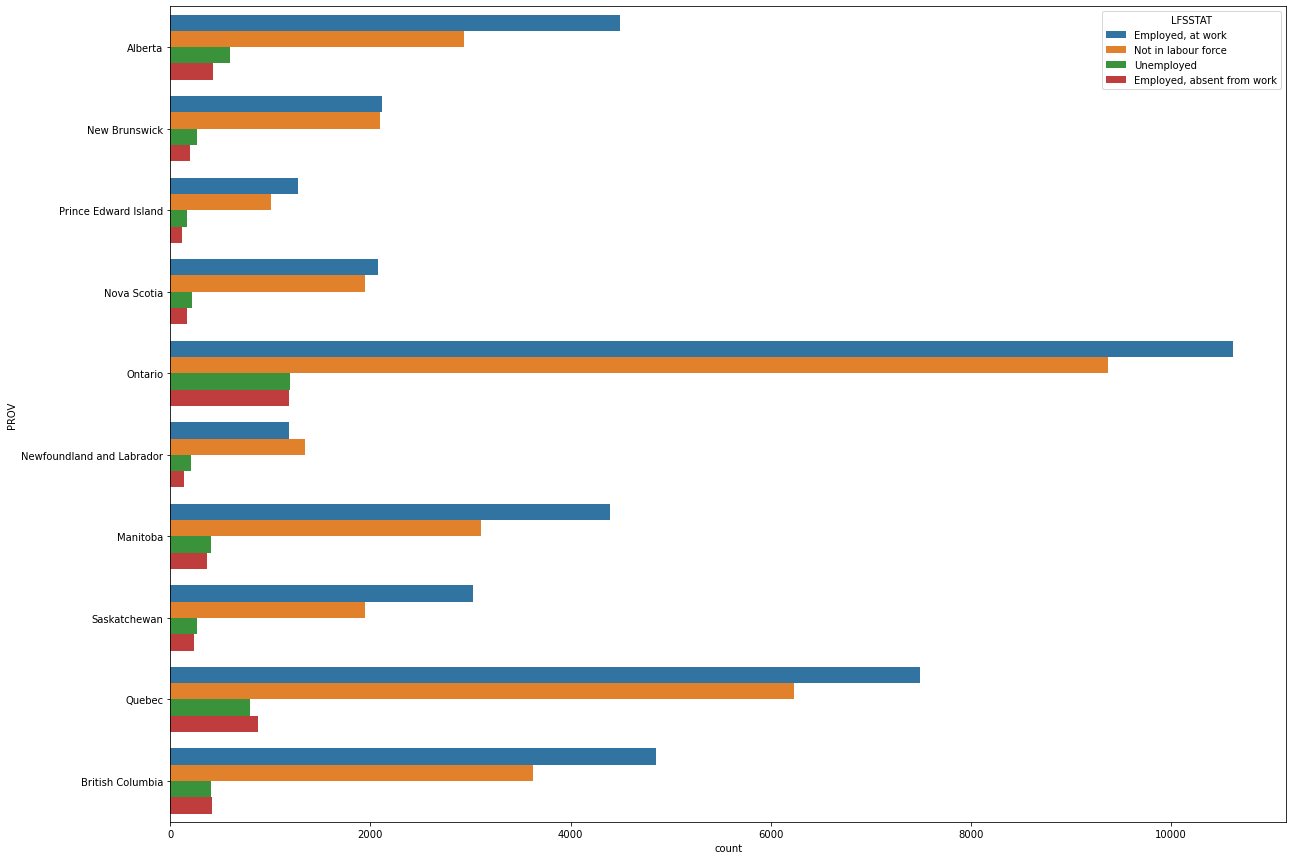

In [11]:
plt.figure(figsize = (20, 15))
sns.countplot(y = unemployment['PROV'], hue = unemployment['LFSSTAT'], orient = 'h')

Observations about the picture above:
- Difference between unemployment rate and labour force is significant, but lots of reasons why there might be a difference

In [12]:
print(unemployment.value_counts())

LFSSTAT                     PROV                     
Employed, at work           Ontario                      10617
Not in labour force         Ontario                       9370
Employed, at work           Quebec                        7488
Not in labour force         Quebec                        6235
Employed, at work           British Columbia              4852
                            Alberta                       4491
                            Manitoba                      4391
Not in labour force         British Columbia              3623
                            Manitoba                      3105
Employed, at work           Saskatchewan                  3026
Not in labour force         Alberta                       2932
Employed, at work           New Brunswick                 2115
Not in labour force         New Brunswick                 2099
Employed, at work           Nova Scotia                   2071
Not in labour force         Nova Scotia                   1950
 

In [13]:
lfs_years = list(set(unemployment.index.get_level_values('MNTHYEAR')))
print(lfs_years)

['2021-01']


In [14]:
metrics_columns = ['month_year', 'unemployment_rate', 'lf_participation_rate']

#generate a dataframe of all the important metrics by year and sort by most recent, need to refactor this - doesn't seem to work unless I have a series with just LFSSTAT
lfs_metrics = pd.DataFrame(columns = metrics_columns)
for month_year in lfs_years:
        #get the count of each labour force status

    emp_values = unemployment.loc[month_year, :].value_counts().sort_index()
    labour_force_participation = emp_values.sum() -  int(emp_values.loc['Not in labour force'])
    

    #define the unemployment rate and labour force participation rate for the data - with any other years this wouldn't work.
    unemployment_rate = (emp_values['Unemployed']/labour_force_participation)*100
    lf_participation_rate = (labour_force_participation/emp_values.sum())*100
    #print(str(month_year) + ' unemployment rate: ' + str(unemployment_rate)+ '%')
    #print(str(month_year) + ' labour force participation rate: ' + str(lf_participation_rate) + '%')
    
    temp_metrics = pd.DataFrame([[month_year, unemployment_rate, lf_participation_rate]], columns = ['month_year', 'unemployment_rate', 'lf_participation_rate'])
    lfs_metrics = pd.concat([lfs_metrics, temp_metrics])

lfs_metrics = lfs_metrics.sort_values('month_year', ascending = False)
print(lfs_metrics.head())
print(lfs_metrics.shape)
print(lfs_metrics.info())
fig, ax = plt.subplots()
ax.plot(lfs_metrics['month_year'], lfs_metrics['unemployment_rate'],)
#x.plot(lfs_metrics['month_year'], lfs_metrics['lf_participation_rate'])
fig.show()
    

TypeError: cannot convert the series to <class 'int'>

In [9]:
lfs_metrics.head()

,month_year,unemployment_rate,lf_participation_rate
0,2022-02,PROV Saskatchewan 4.683715 dtype: float64,65.301459
0,2022-01,PROV Saskatchewan 5.611672 dtype: float64,64.847162
0,2021-12,PROV Saskatchewan 5.108632 dtype: float64,64.118976
0,2021-11,PROV Saskatchewan 4.643499 dtype: float64,63.183797
0,2021-10,PROV Saskatchewan 4.794118 dtype: float64,64.018076


Rates above don't line up with actual unemployment - Feb 2022 was 5.5% on Statscan website, but 5.7% in my own calculations - are there some exclusions made on Statscan calculation or am I doing something wrong?

In [53]:
print(unemployment.value_counts())

SURVYEAR  SURVMNTH   LFSSTAT                   
2022      February   Employed, at work             55276
2021      December   Employed, at work             49565
2022      January    Employed, at work             49563
2021      November   Employed, at work             47910
          June       Employed, at work             46747
          October    Employed, at work             46185
          May        Employed, at work             46004
          September  Employed, at work             45891
          April      Employed, at work             44575
          March      Employed, at work             44385
          February   Employed, at work             43027
          July       Employed, at work             42786
          August     Employed, at work             42686
          January    Employed, at work             41518
2022      February   Not in labour force           40085
          January    Not in labour force           38728
2021      December   Not in labour force

In [55]:
print(type(unemployment.value_counts().sort_index()))
emp_status = unemployment.value_counts().sort_index()
employed = emp_status['2021', 'April', 'Employed, at work']
print(employed)

<class 'pandas.core.series.Series'>


KeyError: ('2021', 'April', 'Employed, at work')

In [43]:
print(unemployment.groupby(['SURVYEAR', 'SURVMNTH']).count())


                    LFSSTAT
SURVYEAR SURVMNTH          
2021     April        87597
         August       86862
         December     92685
         February     85326
         January      83787
         July         86405
         June         87573
         March        86552
         May          88057
         November     89546
         October      86555
         September    86049
2022     February    103658
         January      97899
